# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_17281/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        raise NotImplementedError

# Mean square error Loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return 2 * (predicted - actual) / len(actual)
    
# Binary cross entropy Loss

class BinCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - ((np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - (((actual / predicted - (1 - actual) / (1 - predicted)) / len(actual)))
    
# Categorical cross entropy Loss

class CatCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - (np.sum(actual * np.log(predicted)) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - ((actual / predicted) / len(actual))


### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Stocking the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(4)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs
        
        # Compute the feed forward pass
        """
        (b,i) @ (i,o) + (1,o) = (b,o)
        """
        return inputs @ self.params["w"] + self.params["b"]
        
     
        
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        """
        (i,b) @ (b,o) = (i,o)
        """
        self.grads["b"] = grad
        """
        (b,o) 
        """
        # Compute the feed backward pass
        """
        (b,o) @ (o,i) = (b,i)
        """
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))

def relu(x: Tensor) -> Tensor:
    return np.maximum(0,x)

def relu_prime(x: Tensor) -> Tensor:
    return np.where(x <= 0, 0, 1)

# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        self.lr = lr 
        """
        Learning rate
        """
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
                for name in layer.params.keys():
                    layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Class defining how to organize the data in series of batch

In [6]:
Batch = NamedTuple("Batch", [("inputs", Tensor), ("targets", Tensor)])


class DataIterator:
    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        raise NotImplementedError

        
class BatchIterator(DataIterator):
    def __init__(self, batch_size: int = 32, shuffle: bool = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs: Tensor, targets: Tensor) -> Iterator[Batch]:
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

### Defining the training routine of the network

In [7]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator: DataIterator = BatchIterator(),
        num_epochs: int = 5000,
        UseBatch: bool = False) -> None:

    Loss_list : Sequence = []
    Acc_list : Sequence = []
        
    if UseBatch == True:

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            Predicted_list: Sequence =[] 
            for batch in iterator(inputs, targets):

                Batch_loss : Sequence = []
                Batch_grad : Sequence = []
                Batch_acc : Sequence = []

                predicted = net.forward(batch[0])
                for i in predicted:
                    Predicted_list.append(i)
                Batch_loss.append(loss.loss(predicted, batch[1]))
                grad = loss.grad(predicted, batch[1])
                Batch_grad.append(grad) 
                net.backward(grad)
                net.optimize()
                
                Batch_acc.append(np.mean(predicted.round()==batch[1]) * 100)
                
            epoch_loss = np.mean(Batch_loss)
            epoch_acc = np.mean(Batch_acc)

            Loss_list.append(epoch_loss)
            Acc_list.append(epoch_acc)
                    
            # Print status every 100 iterations
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)
        
        print("Targets - Predictions - Results")
        for y, z in zip(targets, Predicted_list):
            print(f'{y} => {z} => {z.round()}')


    else:
            
        for epoch in range(num_epochs):
            epoch_loss = 0.0

            predicted = net.forward(inputs)
            epoch_loss = loss.loss(predicted, targets)
            epoch_grad = loss.grad(predicted, targets)
            net.backward(epoch_grad)
            net.optimize()
                
            epoch_acc = np.mean(predicted.round()==targets) * 100

            Loss_list.append(epoch_loss)
            Acc_list.append(epoch_acc)
                    
            # Print status every 100 iterations
            if epoch % 100 == 0:
                print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)

        
        print("Targets - Predictions - Results")
        for y, z in zip(targets, predicted):
            print(f'{y} => {z} => {z.round()}')
        
        
    plt.plot(Acc_list)
    plt.ylabel('Accuracy')
    plt.xlabel("Epochs:")
    plt.show()
    
    plt.plot(Loss_list)
    plt.ylabel('Loss')
    plt.xlabel("Epochs:")
    plt.show()


### Validation Process

In [8]:
def validate(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError(),
        iterator: DataIterator = BatchIterator(),
        UseBatch: bool = False) -> None:

    if UseBatch == True:
        
        Predicted_list: Sequence =[] 

        for batch in iterator(inputs, targets):

            Batch_loss : Sequence = []
            Batch_acc : Sequence = [] 

            predicted = net.forward(batch[0])
            for i in predicted:
                    Predicted_list.append(i)
            
            Batch_loss.append(loss.loss(predicted, batch[1]))   
            Batch_acc.append(np.mean(predicted.round()==batch[1]) * 100)
   
        val_loss = np.mean(Batch_loss)
        val_acc = np.mean(Batch_acc)
        
        print("Targets - Predictions - Results")
        for y, z in zip(targets, Predicted_list):
            print(f'{y} => {z} => {z.round()}')

    else:

        predicted = net.forward(inputs)
        
        val_loss = loss.loss(predicted, targets)
        val_acc = np.mean(predicted.round()==targets) * 100

        print("Targets - Predictions - Results")
        for y, z in zip(targets, predicted):
                print(f'{y} => {z} => {z.round()}')

    print(" Loss = ", val_loss," Acc = ", val_acc)

In [9]:
lines: int = 200

# 2 types of dataset : 12 variables and 3 variables

dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines)

dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines)


dataset1_validation = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines+1, nrows=lines)

dataset2_validation = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines+1, nrows=lines)



labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines)

labels_validation = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines+1, nrows=lines)

# New labels for cross entropy loss

bin_labels_train = np.where(labels_train.values == 0, 0, 1)

bin_labels_validation = np.where(labels_validation.values == 0, 0, 1)


Epoch =  0  Loss =  5.2128600471130255  Acc =  0.0
Epoch =  100  Loss =  0.6339556751154296  Acc =  34.0
Epoch =  200  Loss =  0.4758679336013904  Acc =  34.0
Epoch =  300  Loss =  0.412161829074883  Acc =  34.0
Epoch =  400  Loss =  0.36293797993141186  Acc =  46.5
Epoch =  500  Loss =  0.3262878037148723  Acc =  56.99999999999999
Epoch =  600  Loss =  0.29868211035210046  Acc =  56.49999999999999
Epoch =  700  Loss =  0.27586398387287075  Acc =  78.0
Epoch =  800  Loss =  0.25530885997767055  Acc =  84.0
Epoch =  900  Loss =  0.23655100180510413  Acc =  86.0
Epoch =  1000  Loss =  0.21983142262529398  Acc =  86.5
Epoch =  1100  Loss =  0.20465137315239879  Acc =  88.0
Epoch =  1200  Loss =  0.19027762326915465  Acc =  88.0
Epoch =  1300  Loss =  0.17617195654574888  Acc =  90.0
Epoch =  1400  Loss =  0.16207776762583548  Acc =  90.5
Epoch =  1500  Loss =  0.1481375536629298  Acc =  91.0
Epoch =  1600  Loss =  0.13487753682103346  Acc =  91.0
Epoch =  1700  Loss =  0.12272255842899149

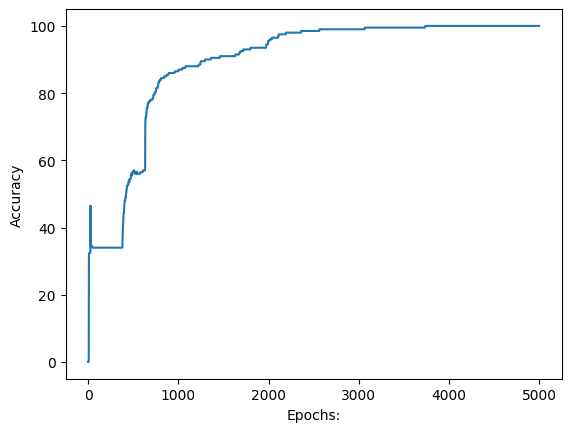

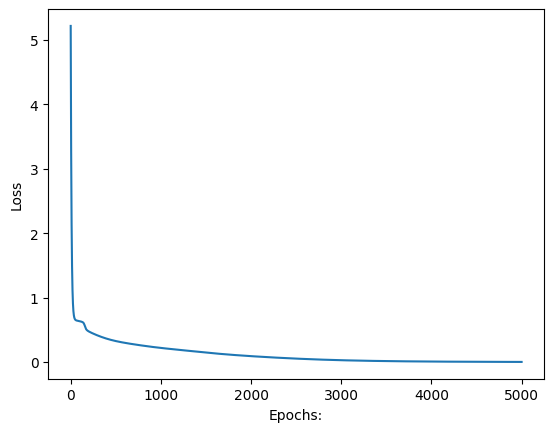

Targets - Predictions - Results
[0] => [0.32917831] => [0.]
[1] => [1.65274041] => [2.]
[2] => [1.04984296] => [1.]
[1] => [1.48073774] => [1.]
[2] => [1.05319084] => [1.]
[1] => [2.29434563] => [2.]
[2] => [0.24576775] => [0.]
[1] => [1.23202242] => [1.]
[0] => [0.24050827] => [0.]
[2] => [1.23456309] => [1.]
[1] => [1.98256923] => [2.]
[2] => [1.05941837] => [1.]
[1] => [1.97284343] => [2.]
[0] => [-0.1086023] => [-0.]
[0] => [-0.20537739] => [-0.]
[1] => [1.9675604] => [2.]
[1] => [0.22531765] => [0.]
[2] => [1.43425118] => [1.]
[2] => [1.96763024] => [2.]
[2] => [1.04225715] => [1.]
[1] => [0.2169014] => [0.]
[0] => [0.21651443] => [0.]
[0] => [0.22165284] => [0.]
[2] => [1.42275408] => [1.]
[1] => [1.73331271] => [2.]
[1] => [1.59899424] => [2.]
[2] => [1.77521462] => [2.]
[1] => [1.06256369] => [1.]
[2] => [1.05575083] => [1.]
[2] => [2.72762661] => [3.]
[1] => [1.04148691] => [1.]
[1] => [1.96163343] => [2.]
[2] => [1.79943373] => [2.]
[2] => [0.97534827] => [1.]
[1] => [1.41335

In [10]:
seed_value: bool = False
batch_value: bool = False
batch_num: int = 20
shuffle_value: bool = False

net1 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
])

train(net1, inputs=dataset1_train.values, targets=labels_train.values, loss=MeanSquareError(), 
      UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value), num_epochs=5000)

validate(net1, inputs=dataset1_validation.values, targets=labels_validation.values, loss=MeanSquareError(), 
         UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value))

Epoch =  0  Loss =  1.4195705177980154  Acc =  49.5
Epoch =  100  Loss =  0.7427189553065695  Acc =  61.5
Epoch =  200  Loss =  0.5261074335732312  Acc =  71.5
Epoch =  300  Loss =  0.4218181874559825  Acc =  78.0
Epoch =  400  Loss =  0.3764241771150628  Acc =  79.0
Epoch =  500  Loss =  0.33642501169358313  Acc =  87.5
Epoch =  600  Loss =  0.30570725768929186  Acc =  89.5
Epoch =  700  Loss =  0.2802623514079518  Acc =  90.0
Epoch =  800  Loss =  0.2566532140644215  Acc =  91.0
Epoch =  900  Loss =  0.23415346788907082  Acc =  91.5
Epoch =  1000  Loss =  0.21235085869561834  Acc =  93.0
Epoch =  1100  Loss =  0.19163459619592815  Acc =  95.5
Epoch =  1200  Loss =  0.17278890462424143  Acc =  97.0
Epoch =  1300  Loss =  0.15629580977161542  Acc =  97.0
Epoch =  1400  Loss =  0.14212145294242387  Acc =  97.5
Epoch =  1500  Loss =  0.1298022519544181  Acc =  97.5
Epoch =  1600  Loss =  0.11896613943301122  Acc =  98.5
Epoch =  1700  Loss =  0.10966062294386696  Acc =  98.5
Epoch =  180

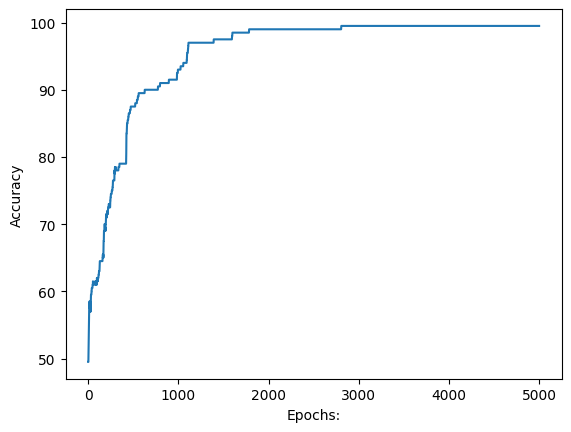

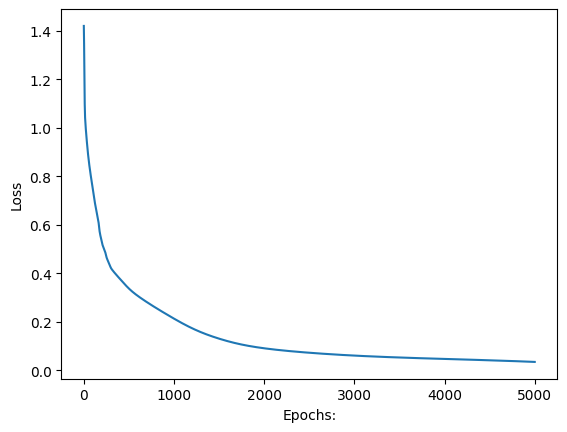

Targets - Predictions - Results
[0] => [0.05587937] => [0.]
[1] => [0.99937693] => [1.]
[1] => [0.99938222] => [1.]
[1] => [0.99939254] => [1.]
[1] => [0.99936661] => [1.]
[1] => [0.99925517] => [1.]
[1] => [0.0693905] => [0.]
[1] => [0.14663126] => [0.]
[0] => [0.9952154] => [1.]
[1] => [0.99828921] => [1.]
[1] => [0.99937897] => [1.]
[1] => [0.9363952] => [1.]
[1] => [0.94152919] => [1.]
[0] => [0.74595099] => [1.]
[0] => [0.05012663] => [0.]
[1] => [0.99941774] => [1.]
[1] => [0.99701139] => [1.]
[1] => [0.99932324] => [1.]
[1] => [0.9993833] => [1.]
[1] => [0.99941709] => [1.]
[1] => [0.03993251] => [0.]
[0] => [0.04551073] => [0.]
[0] => [0.06441933] => [0.]
[1] => [0.99574628] => [1.]
[1] => [0.998865] => [1.]
[1] => [0.99783488] => [1.]
[1] => [0.99729328] => [1.]
[1] => [0.99917526] => [1.]
[1] => [0.93593124] => [1.]
[1] => [0.9993918] => [1.]
[1] => [0.99936481] => [1.]
[1] => [0.99937262] => [1.]
[1] => [0.99788358] => [1.]
[1] => [0.99885741] => [1.]
[1] => [0.99934614] => 

In [11]:
net2 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

train(net2, inputs=dataset1_train.values, targets=bin_labels_train, loss=BinCrossEntropy(), 
      UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value), num_epochs=5000)

validate(net2, inputs=dataset1_validation.values, targets=bin_labels_validation, loss=BinCrossEntropy(), 
         UseBatch=batch_value, iterator=BatchIterator(batch_size=batch_num, shuffle=shuffle_value))
